**CS 342 - Machine Learning**

**GMM for Clustering**





In [3]:
#importing packages

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import patches
from matplotlib.patches import Ellipse

import plotly.express as px
import plotly.graph_objects as go

from sklearn.cluster import KMeans
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

from scipy.stats import multivariate_normal 


**Part A - Loading the Iris Dataset**

In [4]:
#A - Loading dataset

#loading the iris dataset and assigning column names
df_iris = pd.read_csv('iris.data', header = None)
df_iris.columns =['sepal_length', 'sepal_width', 'petal_length', 'petal_width','class']

#checking the first five rows of the iris dataset
df_iris.head()


,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


**Part B - Performing Principal Componenet Analysis on Iris Dataset**

In [5]:
#B - Performing PCA

# Split iris dataframe
iris_feat = df_iris.drop(columns=['class'])
iris_class = df_iris['class']

# Standardization
iris_feat = StandardScaler().fit_transform(iris_feat)
iris_feat = pd.DataFrame(iris_feat)

# Singular Value Decomposition
u,s,v = np.linalg.svd(iris_feat)

# Estimate singular values
singular_values = s*s/(iris_feat.shape[0]-1)

# Generate PCA in 2D take top 2  singular values and eigenvectors
# Data in reduced dimension
iris_feat_PCA = np.matmul (np.array (iris_feat), v.T[ :,:2]) #Projection Matrix:  v.T[:,:2]

# Visualize the samples in reduced space
iris_PCA_out = pd.concat([pd.DataFrame( iris_feat_PCA),pd.DataFrame( df_iris['class'])], axis=1)
iris_PCA_out = iris_PCA_out.rename(columns={0:"PC 1",1:"PC 2"})

#Visualising the data-points of the Iris Dataset in 2D by projecting the data onto the top two PCs
fig = px.scatter(iris_PCA_out, x='PC 1' , y='PC 2', color='class', template='plotly_white',
                 title="PCA")
fig.update_layout(title_x=0.4)
fig.show()


**Part C - K means Clustering**

In [13]:
# K-means Clustering

#C.1 

#Use k-means model to predict cluster for initialisation

data_init=iris_PCA_out.drop(columns=['class'])

kmeans = KMeans(n_clusters=3)
kmeans.fit(data_init)

#predictions from kmeans

pred = kmeans.predict(data_init)
init_cluster = pd.DataFrame(data_init)
init_cluster['cluster'] = pred

init_cluster.columns = ['PC1', 'PC2', 'cluster']

#Cluster centers for GMM intialisation
mu_init= kmeans.cluster_centers_

#Create weighting, n by k weighting matrix for cluster probs based on KNN initialisation
n_clus=3
cluster_prob_init= np.zeros((data_init.shape[0], n_clus))

for i in range(data_init.shape[0]):
  cluster_assign=data_init.loc[i,"cluster"] 
  cluster_prob_init[i,cluster_assign]=1           

clus_weights_init= np.empty((1,3), int)
for i in range(n_clus):
  clus_weights_init[0,i]=sum(init_cluster.cluster == i)

phi_init=clus_weights_init/clus_weights_init.sum()


**Visualizing the cluster assignment provided by K-means**

In [ ]:
init_cluster_copy = init_cluster.copy()

init_cluster_copy["cluster"] = init_cluster_copy["cluster"].astype(str)

#matching cluster assignment to its corresponding Iris species  
cond= [init_cluster_copy["cluster"] =="1",  init_cluster_copy["cluster"] =="0",  init_cluster_copy["cluster"] =="2" ]
choice= [ "Iris-setosa", 'Iris-virginica', 'Iris-versicolor' ]
    
init_cluster_copy["species"] = np.select(cond, choice, default=np.nan)

#Using Plotly to visualise the K means cluster assignment

fig = px.scatter(init_cluster_copy, x="PC1", y="PC2", color="species", color_discrete_map={"Iris-versicolor": '#EF553B', "Iris-virginica": '#00CC96', "Iris-setosa":"#636EFA"},
                 title="K-means Clustering", template="plotly_white")

#Adding centroids to the scatterplot
fig.add_trace(
    go.Scatter(
        x=kmeans.cluster_centers_[:,0], y=kmeans.cluster_centers_[:,1], mode="markers",
        marker=dict(size=10, color="black"),
        name="centroids")
)
#Adding circles to represent the shape of the clusters 
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=[kmeans.cluster_centers_[0,0]], y=[kmeans.cluster_centers_[0,1]],
        marker=dict(
            color='white',
            opacity=0.2,
            size=170,
            line=dict(
                color='black',
                width=1,
            )
        ),
        showlegend=False
    )
)

fig.add_trace(
    go.Scatter(
        mode='markers',
        x=[kmeans.cluster_centers_[1,0]], y=[kmeans.cluster_centers_[1,1]],
        marker=dict(
            color='white',
            opacity=0.2,
            size=190,
            line=dict(
                color='black',
                width=1,
            )
        ),
        showlegend=False
    )
)
fig.add_trace(
    go.Scatter(
        mode='markers',
        x=[kmeans.cluster_centers_[2,0]], y=[kmeans.cluster_centers_[2,1]],
        marker=dict(
            color='white',
            opacity=0.2,
            size=200,
            line=dict(
                color='black',
                width=1,
            )
        ),
        showlegend=False
    )
)

fig.show()

**Calculating K-means clustering accuracy**

In [81]:
#Kmeans accuracy score

target_names = ['0', '1', '2']
#Classification report
print(classification_report(iris_PCA_out_copy['class2'],kmeans.labels_,target_names=target_names))


#assigning iris species to cluster assignment to calculate accuracy of k means clustering compared to ground truth labels
iris_PCA_out_copy = iris_PCA_out.copy()
iris_PCA_out_copy= iris_PCA_out_copy.rename(columns={"class": "species"})
init_cluster_copy2 = init_cluster_copy.drop(columns=['PC1',"PC2"])
init_cluster_copy2 = init_cluster_copy2.drop_duplicates()
iris_PCA_out_copy = pd.merge(iris_PCA_out_copy, init_cluster_copy2, on="species")
iris_PCA_out_copy= iris_PCA_out_copy.rename(columns={"species": "class"})
iris_PCA_out_copy= iris_PCA_out_copy.rename(columns={"cluster": "class2"})
iris_PCA_out_copy["class2"] = pd.to_numeric(iris_PCA_out_copy["class2"])


iris_accuracy = pd.concat([iris_PCA_out_copy.reset_index(drop=True), pd.DataFrame(kmeans.labels_)], axis=1)
iris_accuracy = iris_accuracy.rename(columns = {0:'km_class'})

iris_accuracy = iris_accuracy.copy()

iris_accuracy['Same'] = np.where( iris_accuracy['class2'] == iris_accuracy['km_class'] , 1, 0)

iris_accuracy_out = pd.DataFrame(columns=['Total', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])

iris_accuracy_out.loc[0,'Total'] = iris_accuracy['Same'].sum()/150 

iris_accuracy_out.loc[0,'Iris-setosa'] = iris_accuracy[iris_accuracy['class'] =='Iris-setosa']['Same'].sum()/50 
iris_accuracy_out.loc[0,'Iris-versicolor'] = iris_accuracy[iris_accuracy['class'] =='Iris-versicolor']['Same'].sum()/50 
iris_accuracy_out.loc[0,'Iris-virginica'] = iris_accuracy[iris_accuracy['class'] =='Iris-virginica']['Same'].sum()/50 






              precision    recall  f1-score   support

           0       0.77      0.72      0.74        50
           1       1.00      1.00      1.00        50
           2       0.74      0.78      0.76        50

    accuracy                           0.83       150
   macro avg       0.83      0.83      0.83       150
weighted avg       0.83      0.83      0.83       150



In [82]:
#Basic accuracy of K means cluster assignment compared to ground truth labels
iris_accuracy_out


,Total,Iris-setosa,Iris-versicolor,Iris-virginica
0,0.833333,1,0.78,0.72


**Clustering using GMM and EM algorithm**

In [134]:
#C.3

class GMM:
    def __init__(self, k, max_iter= 13): # iterations required for convergence found to be 13
        self.k = k  #number of clusters
        self.max_iter = int(max_iter)  #number of iterations

    def initialize(self, X):
        # n row, m col dataframe
        self.shape = X.shape 
        self.n, self.m = self.shape 
        
        # computing the initial values for the EM algorithm here  

        #  initial weights given to each data point wrt to each cluster or P(X_i|z_i=j)
        self.weights = np.full(shape=self.shape, fill_value=1/self.k)

        # initial value of mean of k (number of clusters) Gaussians
        # use kmeans centroids
        self.mu = mu_init

        # initial value of covariance matrix of a mixture k Gaussian distributions
        self.sigma = [ np.cov(X.T) for _ in range(self.k) ] 
        # theta =(mu_i,sigma_i) i=1,...,k
    
   #C.2 

    # Expectation-Step: update weights holding mu and sigma constant
    def e_step(self, X):
        # updated weights or P(X_i/z_i=j)
        self.weights = self.predict_proba(X)
        

    # Maximisation-Step: update mu and sigma holding weights constant
    def m_step(self, X):
        for i in range(self.k):
            weight = self.weights[:, [i]]
            total_weight = weight.sum()
            self.mu[i] = (X * weight).sum(axis=0) / total_weight
            self.sigma[i] = np.cov(X.T,aweights=(weight/total_weight).flatten(), bias=True)

    # fit data points to cluster 
    def fit(self, X):
        # initialise parameters like weights, mu, sigma of all Gaussians in dataset X
        self.initialize(X)
        for iteration in range(self.max_iter):
            # iterate to update the value of P(X_i/z_i=j)
            self.e_step(X)
            # iterate to update the value of mu and sigma as the clusters shift
            self.m_step(X)


    # predicts probability of each data point belonging to each cluster
    def predict_proba(self, X):
        # Creates a n by k matrix with the probability of each point belonging to each cluster
        likelihood = np.zeros( (self.n, self.k) ) 
        for i in range(self.k):
            distribution = multivariate_normal(mean=self.mu[i],cov=self.sigma[i]) #Multivariate Gaussian Distribution
            # pdf 
            likelihood[:,i] = distribution.pdf(X) 

        num = likelihood
        den = num.sum(axis=1)[:, np.newaxis] #create column vector
        weights = num / den #Soft Assignment of points to cluster by probability weighting
        return weights
    
    # predict function for assigning the data point to the cluster with highest probability
    def predict(self, X):
        weights = self.predict_proba(X)
        # Hard Assign data point to cluster with maximum probability
        return np.argmax(weights, axis=1)


In [135]:
data_GMM=iris_PCA_out.drop(columns=['class'])

GMM_final=GMM(3)
GMM_final.initialize(data_GMM)


#GMM Fit 
GMM_final.fit(data_GMM)

#C.4
GMM_final.mu
GMM_final.sigma


#Soft Assignment Probability Weights 
GMM_final.predict_proba(data_GMM) #pi
GMM_final.e_step(data_GMM)
GMM_final.m_step(data_GMM)

#C.5
#Hard Assign Clusters 
GMM_final.predict(data_GMM)

# GMM Classification 
GMM_Class=GMM_final.predict(data_GMM)
GMM_Class = pd.DataFrame(GMM_Class,columns=["Class"])
GMM_output=pd.concat([data_GMM, GMM_Class], axis=1)
              

**Final set of parameters output by the algorithm after convergence**

In [136]:
#C.4 
GMM_final.mu


array([[ 1.31772731,  0.12998719],
       [-2.22048311, -0.29440309],
       [ 0.90069223,  0.16398956]])

In [137]:
#C.4
GMM_final.sigma

[array([[ 0.65612218, -0.33251875],
        [-0.33251875,  0.5877147 ]]), array([[0.03949896, 0.01112109],
        [0.01112109, 0.86817976]]), array([[ 0.56295337, -0.64989651],
        [-0.64989651,  1.17632399]])]

In [138]:
#C.4
GMM_final.predict_proba(data_GMM) #pi

array([[1.61576131e-008, 9.99999984e-001, 1.60220940e-014],
       [1.87868748e-005, 9.99981203e-001, 9.68451886e-009],
       [6.56789239e-007, 9.99999343e-001, 1.01784712e-011],
       [2.77502363e-006, 9.99997225e-001, 2.19872838e-010],
       [2.84788100e-009, 9.99999997e-001, 4.27886237e-016],
       [2.54608914e-010, 1.00000000e+000, 2.37378349e-017],
       [7.05353255e-008, 9.99999929e-001, 9.58009114e-014],
       [8.27952081e-008, 9.99999917e-001, 3.23688586e-013],
       [1.97053900e-005, 9.99980283e-001, 1.20225102e-008],
       [3.28963363e-006, 9.99996710e-001, 3.52206176e-010],
       [1.43973708e-009, 9.99999999e-001, 3.34535428e-016],
       [7.18339954e-008, 9.99999928e-001, 1.86474156e-013],
       [7.63993410e-006, 9.99992358e-001, 1.92559935e-009],
       [1.11046654e-005, 9.99988895e-001, 3.73572755e-010],
       [4.40625518e-012, 1.00000000e+000, 2.58498938e-020],
       [3.55466455e-015, 1.00000000e+000, 3.28838845e-025],
       [5.45133811e-011, 1.00000000e+000

In [139]:
# Cluster assignment by GMM
GMM_final.predict(data_GMM)


array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 2,
       2, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0, 0, 0, 2, 2, 0, 2, 0, 0, 0, 2,
       0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 2, 2])

**Visualizing GMM and EM cluster assignment - Using  Matplotlib to display cluster shape**

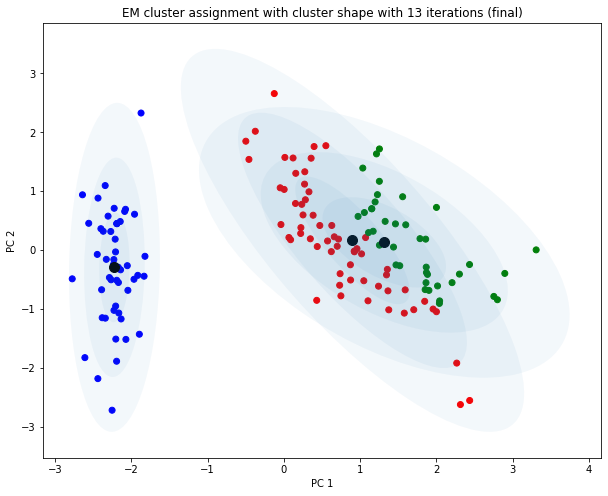

In [141]:
#Visualizing the cluster assignment by GMM and EM algorithm 
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)

groups = GMM_output.groupby('Class')

colors = {1:'blue', 0:'green', 2:'red'}

ax.scatter(GMM_output['PC 1'], GMM_output['PC 2'], c=GMM_output['Class'].map(colors) )
ax.set_xlabel('PC 1')
ax.set_ylabel('PC 2')
ax.set_title('EM cluster assignment with cluster shape with 13 iterations (final)')

#plotting the cluster centers
ax.scatter(GMM_final.mu[:,0],GMM_final.mu[:,1], c="black", s=100)

#using the code from the draw_ellipse function provided to draw ellipses around the clusters

for i in range(0,3):
  U,s,Vt = np.linalg.svd(GMM_final.sigma[i])
  angle_ellipse = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
  width, height = 2 * np.sqrt(s)
  ax.add_patch(patches.Ellipse((GMM_final.mu[i][0], GMM_final.mu[i][1]), width, height,
                     angle=angle_ellipse, linewidth=2, zorder=1, alpha=0.05))
  ax.add_patch(patches.Ellipse((GMM_final.mu[i][0], GMM_final.mu[i][1]), 2*width, 2*height,
                     angle=angle_ellipse, linewidth=2, alpha=0.05, zorder=1))
  ax.add_patch(patches.Ellipse((GMM_final.mu[i][0], GMM_final.mu[i][1]), 3*width, 3*height,
                     angle=angle_ellipse, linewidth=2, zorder=1, alpha=0.05))

plt.show()

**Visualizing GMM and EM cluster assignment - Using  Plotly for an interactive visualization**


In [144]:

GMM_output_copy = GMM_output.copy()

GMM_output_copy["Class"] = GMM_output_copy["Class"].astype(str)

#match cluster assignment to its corresponding Iris species  
cond2= [GMM_output_copy["Class"] =="1",  GMM_output_copy["Class"] =="0",  GMM_output_copy["Class"] =="2" ]
choice2= [ "Iris-setosa", 'Iris-virginica', 'Iris-versicolor' ]
    
GMM_output_copy["species"] = np.select(cond2, choice2, default=np.nan)

fig = px.scatter(GMM_output_copy, x="PC 1", y="PC 2", color="species", #color_discrete_map={"Iris-versicolor": '#EF553B', "Iris-virginica": '#00CC96', "Iris-setosa":"#636EFA"},
                 title="GMM and EM Algorithm Clustering", template="plotly_white")


fig.add_trace(
    go.Scatter(
        x=GMM_final.mu[:,0], y=GMM_final.mu[:,1], mode="markers",
        marker=dict(size=10, color="black"),
        name="centroids")
)
fig.show()

# note that cluster shape is not drawn in this Plotly visual since the draw_ellipse function provided
# uses add_patch from the matplotlib package - and does not work with Plotly.

**Calculating GMM and EM algorithm clustering accuracy**

In [145]:
#accuracy of GMM

target_names = ['0', '1', '2']

iris_PCA_out['class'] 

#GMM accuracy score
iris_PCA_out_copy2 = iris_PCA_out.copy()


#assigning iris species to cluster assignment to calculate accuracy of GMM clustering compared to ground truth labels

iris_PCA_out_copy2= iris_PCA_out_copy2.rename(columns={"class": "species"})
GMM_output_copy2 = GMM_output_copy.drop(columns=['PC 1',"PC 2"])
GMM_output_copy2 = GMM_output_copy2.drop_duplicates()
iris_PCA_out_copy2 = pd.merge(iris_PCA_out_copy2, GMM_output_copy2, on="species")
iris_PCA_out_copy2= iris_PCA_out_copy2.rename(columns={"species": "class"})
iris_PCA_out_copy2= iris_PCA_out_copy2.rename(columns={"Class": "class2"})
iris_PCA_out_copy2["class2"] = pd.to_numeric(iris_PCA_out_copy2["class2"])

iris_GMM_accuracy = pd.concat([iris_PCA_out_copy2.reset_index(drop=True), 
                               pd.DataFrame(GMM_final.predict(data_GMM))], axis=1)
iris_GMM_accuracy = iris_GMM_accuracy.rename(columns = {0:'gmm_class'})

iris_GMM_accuracy = iris_GMM_accuracy.copy()

iris_GMM_accuracy['Same'] = np.where( iris_GMM_accuracy['class2'] == iris_GMM_accuracy['gmm_class'] , 1, 0)

iris_GMM_accuracy_out = pd.DataFrame(columns=['Total', 'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'])

iris_GMM_accuracy_out.loc[0,'Total'] = iris_GMM_accuracy['Same'].sum()/150 

iris_GMM_accuracy_out.loc[0,'Iris-setosa'] = iris_GMM_accuracy[iris_accuracy['class'] =='Iris-setosa']['Same'].sum()/50 
iris_GMM_accuracy_out.loc[0,'Iris-versicolor'] = iris_GMM_accuracy[iris_accuracy['class'] =='Iris-versicolor']['Same'].sum()/50 
iris_GMM_accuracy_out.loc[0,'Iris-virginica'] = iris_GMM_accuracy[iris_accuracy['class'] =='Iris-virginica']['Same'].sum()/50 

#classification report
print(classification_report(iris_PCA_out_copy2['class2'],GMM_final.predict(data_GMM),target_names=target_names))




              precision    recall  f1-score   support

           0       0.87      0.68      0.76        50
           1       1.00      1.00      1.00        50
           2       0.74      0.90      0.81        50

    accuracy                           0.86       150
   macro avg       0.87      0.86      0.86       150
weighted avg       0.87      0.86      0.86       150



In [146]:
#Basic accuracy of GMM cluster assignment compared to ground truth labels

iris_GMM_accuracy_out #13 iterations - final

,Total,Iris-setosa,Iris-versicolor,Iris-virginica
0,0.86,1,0.9,0.68
